In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

import sys
sys.path.append('..') # for the download module which is used by vgg16

from IPython.display import Image, display

In [2]:
import vgg16
vgg16.maybe_download()

Data has been already downloaded and unpacked


In [3]:
# helper functions for image manipulation
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)
    
    if max_size is not None:
        factor = max_size / np.max(image.size)
        size = np.array(image.size) * factor
        size = size.astype(int)
        
        image = image.resize(size, PIL.Image.LANCZOS)
    
    return np.float32(image)

def save_image(image, filename):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

def plot_image_big(image):
    image = np.clip(image, 0.0, 255.0)
    image = image.astype(np.uint8)
    
    display(PIL.Image.fromarray(image))

def plot_images(content, style, mixed, smooth=True):
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    
    interpolation = 'sinc' if smooth else 'nearest'
    
    images = [content, style, mixed]
    for ax, img in zip(axes.flat, images):
        ax.imshow(img / 255.0, interpolation=interpolation)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [4]:
# loss functions
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

def create_content_loss(session, model, content_image, layer_ids):
    feed_dict = model.create_feed_dict(image=content_image)
    layers = model.get_layer_tensors(layer_ids)
    
    values = session.run(layers, feed_dict=feed_dict)
    
    with model.graph.as_default():
        layer_losses = []
        
        for value, layer in zip(values, layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(layer, value_const)
            layer_losses.append(loss)
        
        total_loss = tf.reduce_mean(layer_losses)
    
    return total_loss

def gram_matrix(tensor):
    shape = tensor.get_shape()
    num_channels = int(shape[3])
    matrix =  tf.reshape(tensor, shape=[-1, num_channels])
    
    return tf.matmul(tf.transpose(matrix), matrix)

def create_style_loss(session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict(image=style_image)
    layers = model.get_layer_tensors(layer_ids)
    
    gram_layers = [gram_matrix(layer) for layer in layers]
    values = session.run(gram_layers, feed_dict=feed_dict)

    with model.graph.as_default():
        layer_losses = []
        
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            loss = mean_squared_error(gram_layer, value_const)
            layer_losses.append(loss)
        
        total_loss = tf.reduce_mean(layer_losses)
    
    return total_loss

def create_denoise_loss(model):
    return tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

In [5]:
# style transfer algorithm
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iter=120, step_size=10.0):
    model = vgg16.VGG16()
    session = tf.InteractiveSession(graph=model.graph)
    
    print('Content layers:')
    print(model.get_layer_names(content_layer_ids))
    print('\nStyle layers:')
    print(model.get_layer_names(style_layer_ids))
    
    loss_content = create_content_loss(session, model, content_image,
                                       content_layer_ids)
    loss_style = create_style_loss(session, model, style_image,
                                   style_layer_ids)
    loss_denoise = create_denoise_loss(model)
    
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
    
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])
    
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise
    
    gradient = tf.gradients(loss_combined, model.input)
    
    run_list = [gradient, update_adj_content, update_adj_style, update_adj_denoise]
    
    mixed_image = content_image + 6 * np.random.randn(*content_image.shape)
    
    for i in range(num_iter):
        feed_dict = model.create_feed_dict(image=mixed_image)
        grad, adj_content_val, adj_style_val, adj_denoise_val = session.run(run_list, feed_dict=feed_dict)

        grad = np.squeeze(grad)
        step_size_scaled = step_size / (np.std(grad) + 1e-8)
        mixed_image -= grad * step_size_scaled
        mixed_image = np.clip(mixed_image, 0.0, 255.0)
        print(". ", end="")
        
        if (i % 30 == 0) or (i == num_iter - 1):
            print('\nIteration:', i)
            msg = 'Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}'
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))
            
            plot_images(content_image, style_image, mixed_image)
    
    print('\nFinal Image:')
    plot_image_big(mixed_image)
    
    session.close()
    
    return mixed_image

Content layers:
['conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']
. 
Iteration: 0
Weight Adj. for Content: 1.55e-09, Style: 8.26e-29, Denoise: 1.15e-07


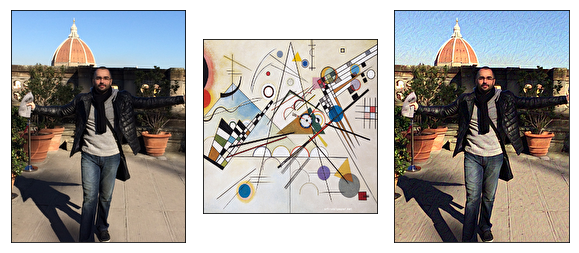

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 6.96e-11, Style: 1.29e-27, Denoise: 9.28e-08


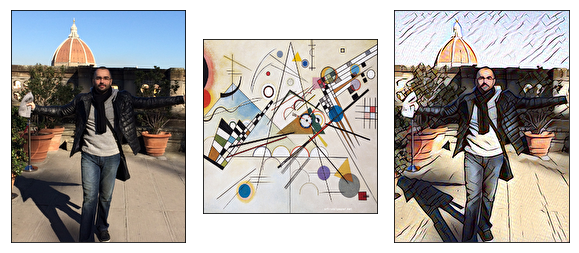

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 6.20e-11, Style: 1.37e-27, Denoise: 9.35e-08


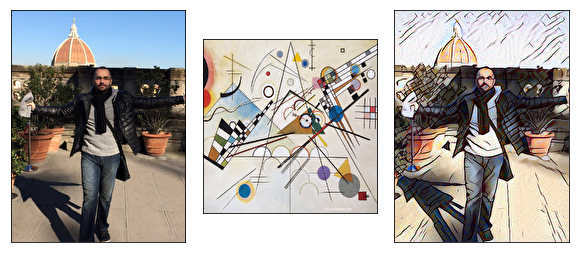

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 5.75e-11, Style: 1.97e-27, Denoise: 9.04e-08


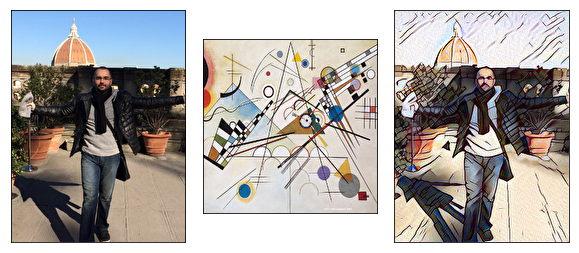

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 5.72e-11, Style: 1.68e-27, Denoise: 8.80e-08


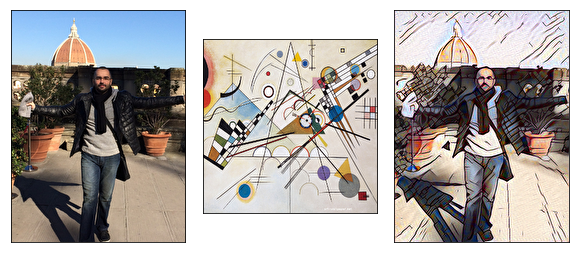

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 5.41e-11, Style: 2.04e-27, Denoise: 8.71e-08


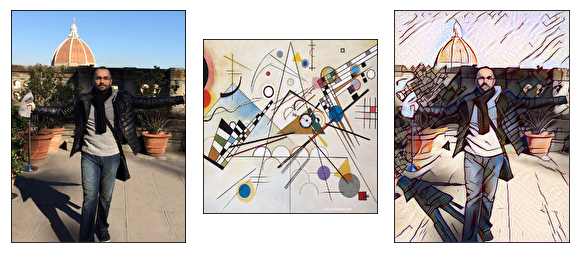

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 5.49e-11, Style: 1.90e-27, Denoise: 8.46e-08


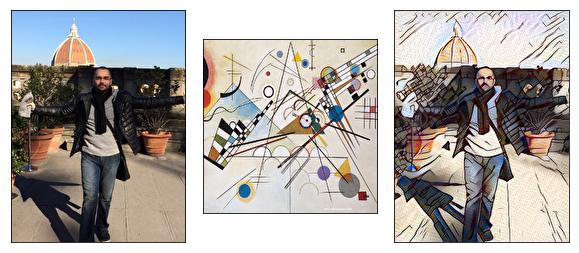

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 210
Weight Adj. for Content: 5.39e-11, Style: 2.11e-27, Denoise: 8.26e-08


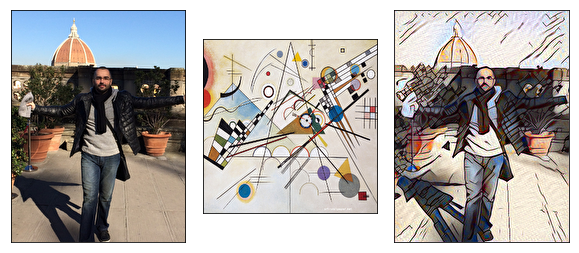

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 240
Weight Adj. for Content: 5.28e-11, Style: 2.39e-27, Denoise: 8.30e-08


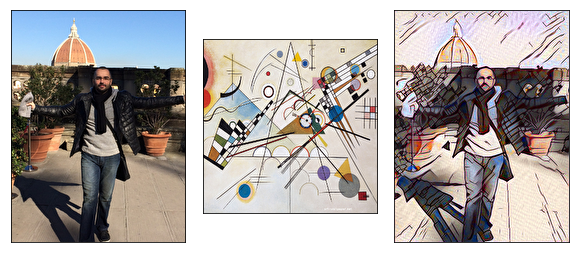

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 270
Weight Adj. for Content: 5.21e-11, Style: 3.01e-27, Denoise: 8.23e-08


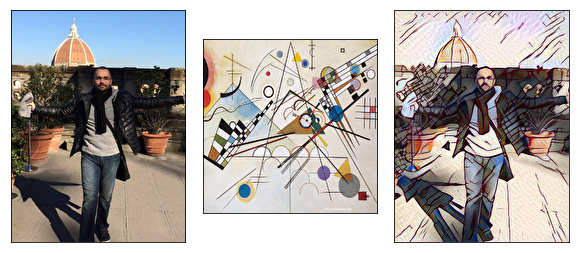

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 299
Weight Adj. for Content: 3.56e-11, Style: 6.21e-28, Denoise: 6.94e-08


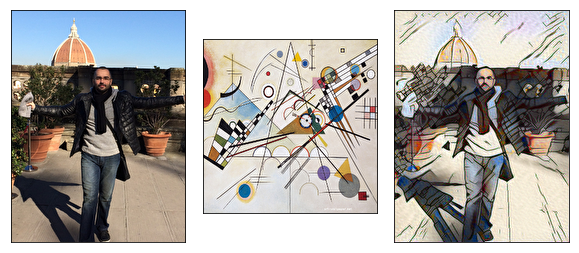


Final Image:


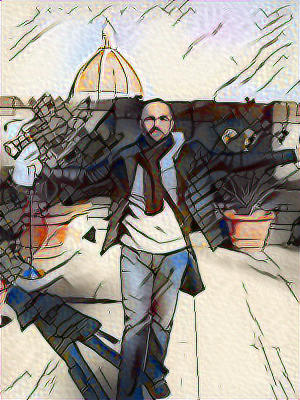

CPU times: user 32.5 s, sys: 8.66 s, total: 41.2 s
Wall time: 38.9 s


In [6]:
%%time
content_file = './images/me.jpg'
style_file = './images/kandinsky.jpg'

content_image = load_image(content_file)
style_image = load_image(style_file)

content_layer_ids = [4,5,6]
style_layer_ids = list(range(13))

img = style_transfer(content_image, style_image,
                     content_layer_ids, style_layer_ids,
                     weight_content=1.5, weight_style=7.0,
                     weight_denoise=0.3,
                     num_iter=300, step_size=10.0)

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']
. 
Iteration: 0
Weight Adj. for Content: 4.56e-09, Style: 1.41e-28, Denoise: 4.19e-08


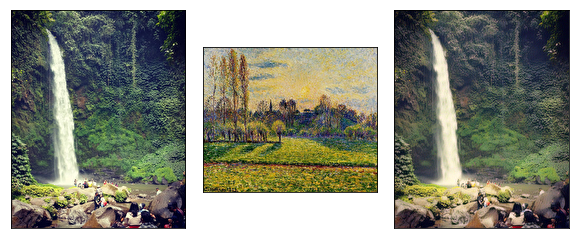

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 3.97e-10, Style: 2.23e-28, Denoise: 3.85e-08


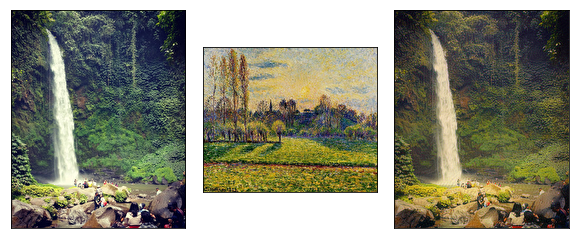

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 3.55e-10, Style: 2.24e-28, Denoise: 3.69e-08


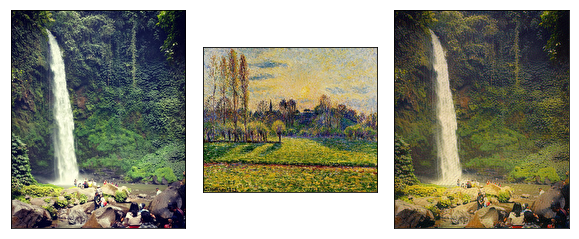

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 3.44e-10, Style: 2.09e-28, Denoise: 3.70e-08


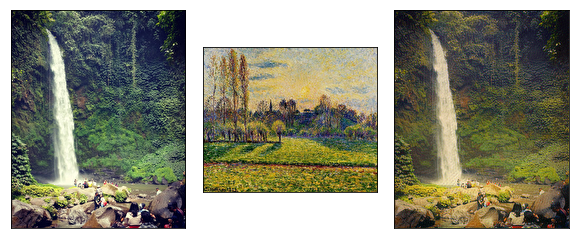

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 3.89e-10, Style: 2.42e-28, Denoise: 3.69e-08


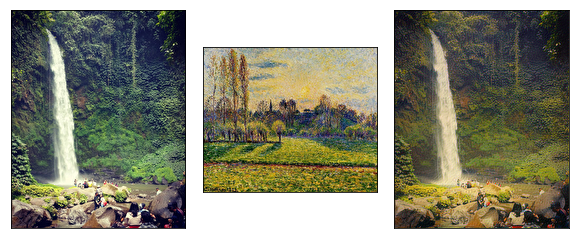

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 4.20e-10, Style: 2.51e-28, Denoise: 3.52e-08


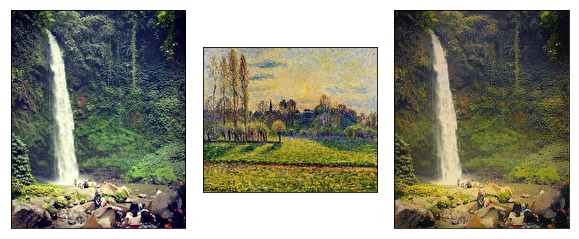

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 4.28e-10, Style: 2.53e-28, Denoise: 3.54e-08


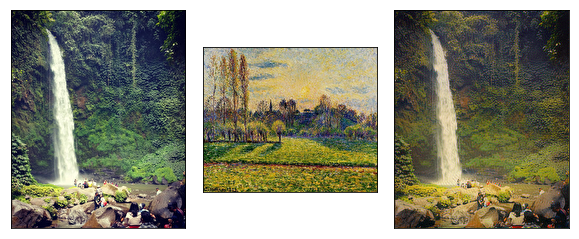

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 210
Weight Adj. for Content: 3.86e-10, Style: 2.83e-28, Denoise: 3.46e-08


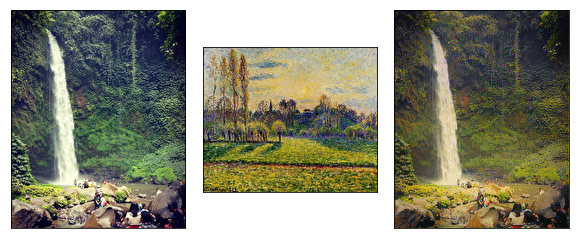

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 240
Weight Adj. for Content: 4.37e-10, Style: 2.56e-28, Denoise: 3.52e-08


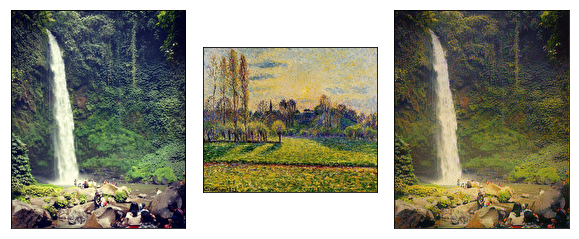

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 270
Weight Adj. for Content: 3.94e-10, Style: 3.35e-28, Denoise: 3.47e-08


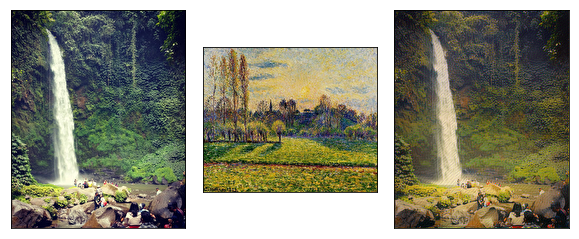

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Iteration: 299
Weight Adj. for Content: 4.50e-10, Style: 3.77e-27, Denoise: 4.12e-08


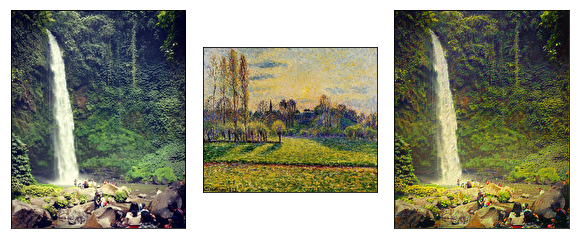


Final Image:


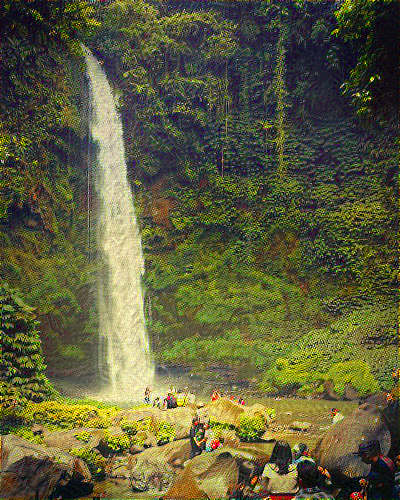

CPU times: user 39.9 s, sys: 11.3 s, total: 51.2 s
Wall time: 52.5 s


In [7]:
%%time
content_file = './images/bali-waterfall.jpg'
style_file = './images/pissarro.jpg'

content_image = load_image(content_file)
style_image = load_image(style_file)

content_layer_ids = [4]
style_layer_ids = list(range(13))

img = style_transfer(content_image, style_image,
                     content_layer_ids, style_layer_ids,
                     weight_content=1.5, weight_style=10.0,
                     weight_denoise=0.3,
                     num_iter=300, step_size=10.0)